<a href="https://colab.research.google.com/github/RVasconcelosMiguel/PerceptionMapping/blob/main/PMT3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.loadtxt('/content/data_slam.txt')

# Extract sections of the data
pose_data = data[:, :3]  # Pose variations: Δx, Δy, Δtheta
lidar_data = data[:, 3:]   # LIDAR measurements

# Parameters for LIDAR
angles = np.deg2rad(np.linspace(-30, 30, 61))  # Angles from -30° to 30°

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Função para converter medições LIDAR para coordenadas cartesianas
def lidar_to_cartesian(lidar_data, angles):
    x_coords = lidar_data * np.cos(angles)
    y_coords = lidar_data * np.sin(angles)
    return np.vstack((x_coords, y_coords)).T  # Transposta para (N, 2)

# Implementação do algoritmo Douglas-Peucker
def douglas_peucker(points, epsilon):
    """
    Simplifica uma linha poligonal usando o algoritmo Douglas-Peucker.
    :param points: Lista de pontos [(x1, y1), (x2, y2), ...].
    :param epsilon: Distância mínima para manter um ponto.
    :return: Pontos simplificados [(x1, y1), (xk, yk), ...].
    """
    # Encontrar a distância máxima de um ponto à linha inicial-final
    start, end = points[0], points[-1]
    line_vector = end - start
    line_length = np.linalg.norm(line_vector)

    if line_length == 0:
        distances = np.linalg.norm(points - start, axis=1)
    else:
        normalized_vector = line_vector / line_length
        projections = np.dot(points - start, normalized_vector)
        projections_points = start + np.outer(projections, normalized_vector)
        distances = np.linalg.norm(points - projections_points, axis=1)

    max_dist_idx = np.argmax(distances)
    max_dist = distances[max_dist_idx]

    # Dividir recursivamente se a distância máxima for maior que epsilon
    if max_dist > epsilon:
        left = douglas_peucker(points[:max_dist_idx + 1], epsilon)
        right = douglas_peucker(points[max_dist_idx:], epsilon)
        return np.vstack((left[:-1], right))
    else:
        return np.array([start, end])

# Função principal para detecção de cantos usando Douglas-Peucker
def detect_corners_douglas_peucker(lidar_data, angles, epsilon):
    corners = []
    lidar_cartesian = lidar_to_cartesian(lidar_data, angles)  # Converter para coordenadas cartesianas

    # Simplificar a linha usando Douglas-Peucker
    simplified_points = douglas_peucker(lidar_cartesian, epsilon)

    # Detectar índices dos pontos simplificados nos dados originais
    for point in simplified_points:
        idx = np.where((lidar_cartesian == point).all(axis=1))[0]
        if len(idx) > 0:
            corners.append(idx[0])


    # Filtrar os pontos iniciais e finais
    corners = [idx for idx in corners if idx != 0 and idx != len(lidar_cartesian) - 1]

    return corners

# Plotar medições LIDAR com os cantos detectados
def plot_lidar_with_corners(lidar_data, corners, angles):
    x_coords, y_coords = lidar_to_cartesian(lidar_data, angles).T
    corner_x, corner_y = x_coords[corners], y_coords[corners]

    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, s=10, label="Medições LIDAR", color='b')
    plt.scatter(corner_x, corner_y, color='r', label="Cantos Detectados", zorder=5)
    plt.axis("equal")
    plt.title("Medições LIDAR com Detecção por Douglas-Peucker")
    plt.xlabel("X (metros)")
    plt.ylabel("Y (metros)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Parâmetros
epsilon = 0.4  # Tolerância para a simplificação

# Iterar sobre as leituras LIDAR
for i in range(len(lidar_data)):
    lidar_row = lidar_data[i]
    corners = detect_corners_douglas_peucker(lidar_row, angles, epsilon)
     # plot_lidar_with_corners(lidar_row, corners, angles)

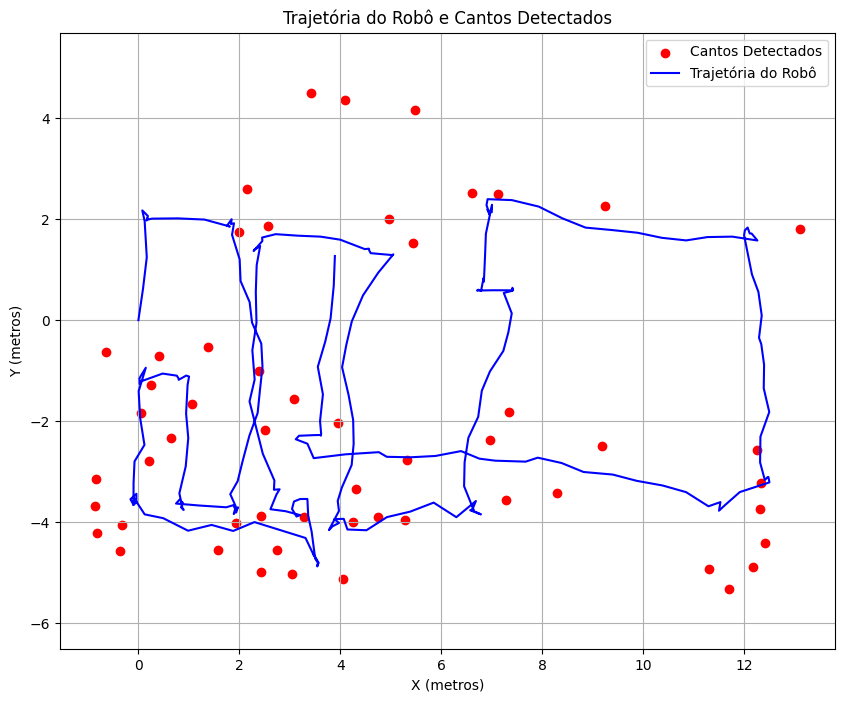

In [50]:
initial_pose = np.array([0.0, 0.0, np.pi / 2])  # Robô começa em (0, 0, pi/2)
P = np.diag([0.1, 0.1, 0.1])
Q = np.diag([0.1, 0.1, 0.05])

R= np.diag([0.1, 0.1])


# Função para atualizar a pose do robô
def update_pose(pose, delta_pose):
    x, y, theta = pose
    dx, dy, dtheta = delta_pose

    # Atualizar a pose
    new_x = x + dx
    new_y = y + dy
    new_theta = theta + dtheta

    return np.array([new_x, new_y, new_theta])

# Função para converter medições LIDAR para coordenadas globais
def lidar_to_global(pose, lidar_distances, angles):
    x_robot, y_robot, theta_robot = pose
    lidar_coords_global = []

    for distance, angle in zip(lidar_distances, angles):
        x_local = distance * np.cos(angle)
        y_local = distance * np.sin(angle)

        rotation_matrix = np.array([
            [np.cos(theta_robot), -np.sin(theta_robot)],
            [np.sin(theta_robot), np.cos(theta_robot)]
        ])

        lidar_local = np.array([x_local, y_local])
        lidar_global = rotation_matrix.dot(lidar_local)
        lidar_global += np.array([x_robot, y_robot])

        lidar_coords_global.append(lidar_global)

    return np.array(lidar_coords_global)


# Lista para armazenar os cantos conhecidos
known_corners = []

# Função para verificar se um canto já é conhecido
def is_known_corner(new_corner, known_corners, threshold=0.5):
    """
    Verifica se um novo canto está próximo de um canto conhecido.
    :param new_corner: Coordenadas do novo canto (x, y).
    :param known_corners: Lista de cantos conhecidos [(x1, y1), ...].
    :param threshold: Distância máxima para considerar o canto como conhecido.
    :return: Índice do canto conhecido ou -1.
    """
    for i, known_corner in enumerate(known_corners):
        distance = np.linalg.norm(new_corner - known_corner)
        if distance < threshold:
            return i
    return -1


def kalman_predict(state, P, delta_pose, pose_noise):
    """
    Prediz o próximo estado e a covariância com base no modelo de movimento.
    """
    # Atualizar o estado com a odometria
    x, y, theta = state
    dx, dy, dtheta = delta_pose
    predicted_state = np.array([
        x + dx ,
        y + dy ,
        theta + dtheta
    ])

    # Atualizar a covariância do estado
    jacobian = np.eye(3)  # Aproximação da derivada do modelo de movimento
    P = jacobian @ P @ jacobian.T + pose_noise

    return predicted_state, P

# Função para processar leituras LIDAR e variações da pose
def kalman_update(pose,P, lidar_data, angles, known_corners):
    """
    Atualiza a pose do robô e o mapa com base nos dados do LIDAR e variações da pose.
    :param pose: Posição atual do robô [x, y, θ].
    :param lidar_data: Leituras do LIDAR (array de distâncias).
    :param angles: Ângulos correspondentes às leituras LIDAR.
    :param known_corners: Lista de cantos conhecidos [(x, y), ...].
    :return: Nova pose do robô e lista atualizada de cantos conhecidos.
    """
    # Converter LIDAR para coordenadas globais
    lidar_coords_global = lidar_to_global(pose, lidar_data, angles)

    # Detectar cantos nos dados LIDAR
    corners_indices = detect_corners_douglas_peucker(lidar_data, angles, epsilon)
    detected_corners = lidar_coords_global[corners_indices]

    new_P = P
    new_pose = pose

    # Atualizar o conjunto de cantos conhecidos
    for corner in detected_corners:
        idx = is_known_corner(corner, known_corners)
        if idx == -1:  # Canto desconhecido
            known_corners.append(corner)

        else :

            z = known_corners[idx]

            z_pred = corner

            y = z - z_pred

            H= np.array([[1, 0, 0],
                        [0, 1, 0]])

            S = H @ P @ H.T + R

            # Ganho de Kalman

            K = P @ H.T @ np.linalg.inv(S)

            # Atualização do estado

            new_pose = pose + K @ y

            # Atualização da covariância

            new_P = (np.eye(len(pose)) - K @ H) @ P


    return new_pose, known_corners,new_P

# Simulação do sistema
robot_pose = initial_pose  # Pose inicial
trajectory = [robot_pose[:2]]  # Trajetória do robô
known_corners = []  # Mapa inicial de cantos

# Processar cada leitura do dataset
for i in range(len(lidar_data)):
    delta_pose = pose_data[i]
    lidar_row = lidar_data[i]

    # Atualizar a pose do robô
    robot_pose,P = kalman_predict(robot_pose,P, delta_pose, Q)

    # Processar os dados LIDAR e atualizar o mapa
    robot_pose, map_corners,P =kalman_update(robot_pose,P, lidar_row, angles, known_corners)

    # Registrar a trajetória
    trajectory.append(robot_pose[:2])

# Visualizar o mapa e a trajetória
map_corners = np.array(map_corners)
trajectory = np.array(trajectory)

plt.figure(figsize=(10, 8))
plt.scatter(map_corners[:, 0], map_corners[:, 1], color='r', label="Cantos Detectados")
plt.plot(trajectory[:, 0], trajectory[:, 1], color='b', label="Trajetória do Robô")
plt.axis("equal")
plt.title("Trajetória do Robô e Cantos Detectados")
plt.xlabel("X (metros)")
plt.ylabel("Y (metros)")
plt.legend()
plt.grid(True)
plt.show()

